In [27]:
#setup
data_dir='../../Data/Weather'
file_index='SBSSBSBB'
m='TOBS'

# Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [28]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [29]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.6 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


/Users/egouda/anaconda2/envs/py27/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['axes', 'eigvals', 'interactive', 'load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [30]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[3]) created by __init__ at <ipython-input-4-a06a223af467>:4 

## Read Statistics File

In [5]:
data_dir='../../Data/Weather'
file_index='SBSSBSBB'

In [6]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [7]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2257.3| 41.7833|-111.5333|       TOBS|USS0011H58S|    32|[00 7E 00 7E 00 7...|2003.0|SBSSBSBB|
|   2257.3| 41.7833|-111.5333|       TOBS|USS0011H58S|    19|[40 D2 A0 D7 A0 D...|2004.0|SBSSBSBB|
|   2257.3| 41.7833|-111.5333|       TOBS|USS0011H58S|     5|[00 D3 80 D1 20 D...|2005.0|SBSSBSBB|
|   2257.3| 41.7833|-111.5333|       TOBS|USS0011H58S|    20|[80 D1 00 00 80 C...|2006.0|SBSSBSBB|
|   2257.3| 41.7833|-111.5333|       TOBS|USS0011H58S|     4|[30 D4 00 CF 80 4...|2007.0|SBSSBSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Create a matrix with all of the series

In [8]:
rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()

T=np.vstack(rows)
shape(T)

(2074, 365)

In [32]:
import pandas as pd


In [33]:
data_test=pd.DataFrame(T)

In [34]:
data_test

0      1      2      3      4      5      6      7      8      9    \
0       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1     -50.0 -122.0 -122.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2     -56.0  -44.0  -33.0 -100.0  -78.0    NaN  -33.0  -50.0   -6.0  -28.0   
3     -44.0    0.0  -22.0  -72.0  -22.0   17.0  -22.0  -83.0  -72.0    6.0   
4     -67.0  -28.0   22.0  -94.0 -139.0 -111.0  -44.0  -17.0  -17.0    6.0   
5     -56.0  -22.0    0.0    6.0  -89.0 -106.0  -94.0  -39.0 -117.0  -44.0   
6      28.0  -78.0    NaN -150.0  -67.0   -6.0    6.0  -44.0  -78.0  -50.0   
7     -17.0  -44.0  -67.0  -28.0  -17.0  -72.0 -111.0  -39.0  -33.0  -22.0   
8    -156.0  -94.0 -111.0 -106.0  -61.0  -44.0  -22.0 -100.0 -161.0 -128.0   
9       6.0   33.0    6.0   22.0   -6.0  -33.0  -83.0  -67.0  -39.0  -61.0   
10    -72.0   -6.0  -50.0 -100.0  -39.0    6.0   39.0   28.0  -39.0  -22.0   
11    -72.0   11.0    6.0   17.0  -17.0    0.0   17.0  -22.0   -6.0  -39.0   
12    -44.0  -94.0 -128.0 -128.0 -150.0  -28.0  -28.0   -6.0   17.0    0.0   
13    -39.0  -28.0  -39.0  -83.0  -78.0 -139.0  -33.0  -28.0   11.0  -11.0   
14      0.0  -11.0  -22.0  -67.0   11.0   61.0  -28.0 -117.0  -61.0   17.0   
15    -61.0  -11.0   22.0  -94.0 -144.0 -106.0  -50.0  -22.0  -11.0    0.0   
16     -6.0    0.0   11.0   28.0  -61.0 -117.0  -94.0  -50.0 -128.0  -39.0   
17     11.0  -72.0 -150.0 -117.0  -67.0  -17.0    6.0  -39.0  -89.0  -50.0   
18     -6.0  -61.0  -61.0  -17.0  -11.0  -56.0  -67.0  -22.0  -28.0    6.0   
19   -150.0  -67.0 -100.0 -111.0  -67.0  -22.0   -6.0  -89.0 -139.0 -156.0   
20     28.0   50.0    6.0   28.0   17.0  -28.0 -100.0  -44.0  -17.0  -50.0   
21    -17.0  -44.0  -72.0  -56.0  -22.0  -22.0   -6.0   33.0  106.0   83.0   
22      NaN  -39.0  -72.0  -61.0  -67.0  -61.0  -22.0  -44.0  -89.0  -61.0   
23      NaN  -50.0  -44.0  -22.0   11.0    0.0  -11.0  -61.0  -56.0  -67.0   
24      NaN   17.0   17.0   33.0  -22.0  -44.0  -28.0  -28.0  -11.0    0.0   
25     33.0   17.0    6.0  -17.0    NaN  -22.0  -50.0  -39.0 -111.0  -78.0   
26    -28.0  -28.0  -33.0  -11.0  -17.0  -11.0  -67.0  -67.0  -33.0  -67.0   
27     11.0  -11.0    0.0   -6.0    6.0  -11.0   -6.0  -11.0    0.0  -17.0   
28     -6.0   17.0   22.0   67.0   -6.0  -39.0  -44.0  -72.0  -39.0  -33.0   
29    -22.0   17.0  -17.0   -6.0   11.0   -6.0  -17.0    0.0   -6.0  -22.0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
2044 -128.0 -117.0 -133.0  -50.0  -61.0  -83.0  -50.0 -128.0 -128.0 -117.0   
2045  -83.0 -100.0  -78.0  -28.0   -6.0   11.0   11.0  -78.0  -72.0  -61.0   
2046 -122.0  -78.0  -56.0  -22.0  -11.0  -44.0  -22.0   17.0   -6.0  -61.0   
2047   11.0   28.0  -17.0  -56.0  -78.0 -100.0  -61.0 -150.0 -122.0 -122.0   
2048  -72.0  -44.0   -6.0   39.0   56.0    6.0   -6.0  -11.0   17.0   22.0   
2049 -167.0 -117.0  -78.0  -39.0 -100.0 -150.0 -128.0 -106.0  -61.0    0.0   
2050    0.0  -28.0    0.0   17.0   67.0  -39.0  -11.0   39.0   44.0  -61.0   
2051  -22.0  -33.0  -11.0   -6.0  -22.0  -22.0  -33.0  -28.0  -33.0  -33.0   
2052  -94.0  -67.0  -17.0   22.0 -106.0    NaN -161.0 -144.0 -128.0 -100.0   
2053  -83.0  -78.0  -50.0    6.0   72.0   44.0   44.0   -6.0  -39.0  -28.0   
2054  -56.0  -89.0  -67.0  -39.0  -28.0  -56.0  -67.0  -61.0  -67.0  -56.0   
2055  -22.0 -100.0 -100.0  -89.0  -67.0  -39.0  -17.0  -11.0  -17.0  -17.0   
2056  -22.0  -11.0   17.0   44.0  -17.0  -28.0  -72.0  -89.0 -111.0 -100.0   
2057  -83.0 -117.0  -83.0  -50.0  -22.0  -22.0  -50.0  -33.0   11.0   39.0   
2058  -83.0  -44.0  -83.0  -50.0   50.0  -94.0  -67.0  -39.0   44.0  -56.0   
2059    NaN  -17.0  -50.0  -39.0    6.0    NaN    NaN    NaN   89.0   61.0   
2060  -67.0  -72.0  -83.0  -56.0  -28.0  -11.0   -6.0  -11.0  -50.0  -39.0   
2061    6.0  -56.0  -72.0  -72.0  -83.0  -67.0  -33.0  -22.0  -28.0  -33.0   
2062   44.0   44.0   44.0   67.0   33.0   -6.0   28.0   22.0   11.0   22.0   
2063  -50.0  -17.0  -22.0    6

### Plot two time series
`SNWD` stands for `snow-depth`, which explains why it is zero during the summer

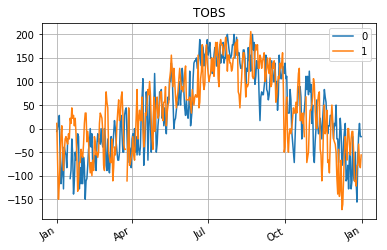

In [9]:
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
YP.plot(T[16:18].transpose(),fig,ax,title=m)

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

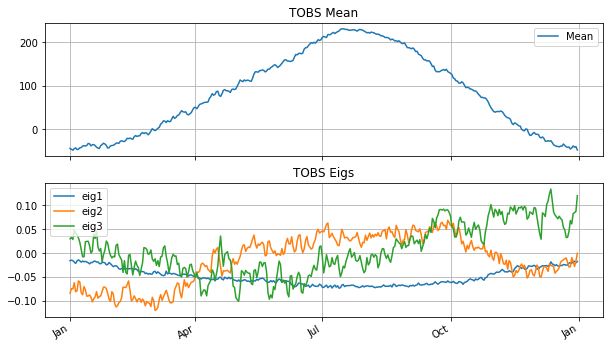

In [10]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

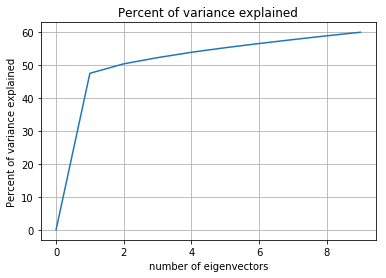

In [11]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [12]:
i=10
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
eigen_decomp=Eigen_decomp(None,T[i],Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

residual normalized norm  after mean: 0.735109461448
residual normalized norm  after mean + top eigs: [ 0.3123007   0.3008554   0.28381293]


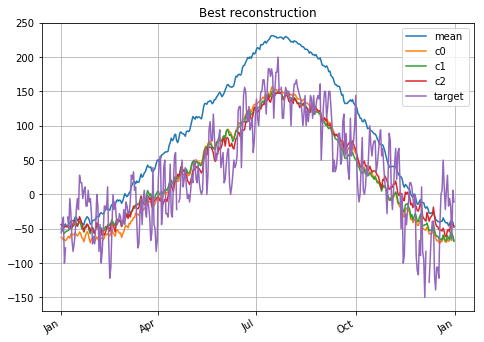

In [13]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [14]:
rows=df.take(3)
L=[]
for row in rows:
    row_out=decompose(row,Mean,v)
    for field in ('res_mean','res_1','res_2','res_3'):
        print field,':',row_out[field],
    print

NameError: name 'decompose' is not defined

In [15]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [16]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 2074
after filter 1913


In [17]:
df3=df3.sort(df3.res_3,ascending=True)
rows=df3.take(12)


In [18]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                    %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None


In [19]:
df3=df3.sort(df3.res_3)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+------------------+-------------------+-------------------+-------------------+
|          res_mean|              res_1|              res_2|              res_3|
+------------------+-------------------+-------------------+-------------------+
|0.1991486315863063| 0.1826078943444634| 0.1610869700821379|0.15423362929474854|
|0.8853250047055105| 0.2261809720852684|0.19573729229767614| 0.1834627933496345|
|0.2061118816411228|0.21390117468860578|0.20941603553200197|0.18874020854303167|
|0.9671858285882693|0.19472268959983446|0.19715965727012125|0.19119033846601105|
+------------------+-------------------+-------------------+-------------------+
only showing top 4 rows



/Users/egouda/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


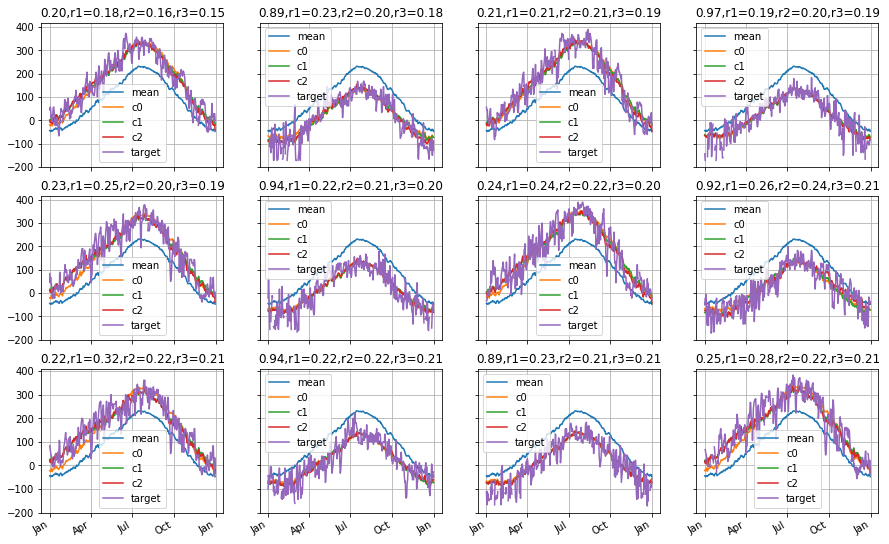

In [20]:
plot_recon_grid(rows)

In [21]:
df3=df3.sort(df3.res_3,ascending=False)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+-------------------+------------------+------------------+------------------+
|           res_mean|             res_1|             res_2|             res_3|
+-------------------+------------------+------------------+------------------+
|0.11601670767783943|1.2443867345450812|1.3116680070227238|1.3330425300831568|
|0.14694473794931742| 1.217359001176077|1.2721497056554216|1.2371396802784385|
|0.21571256758168433|1.2422144211273909|1.2398102419317205|1.2134875035326564|
|0.08837527351072512|1.1145696292009566|1.1035142236958893|1.2108591514060674|
+-------------------+------------------+------------------+------------------+
only showing top 4 rows



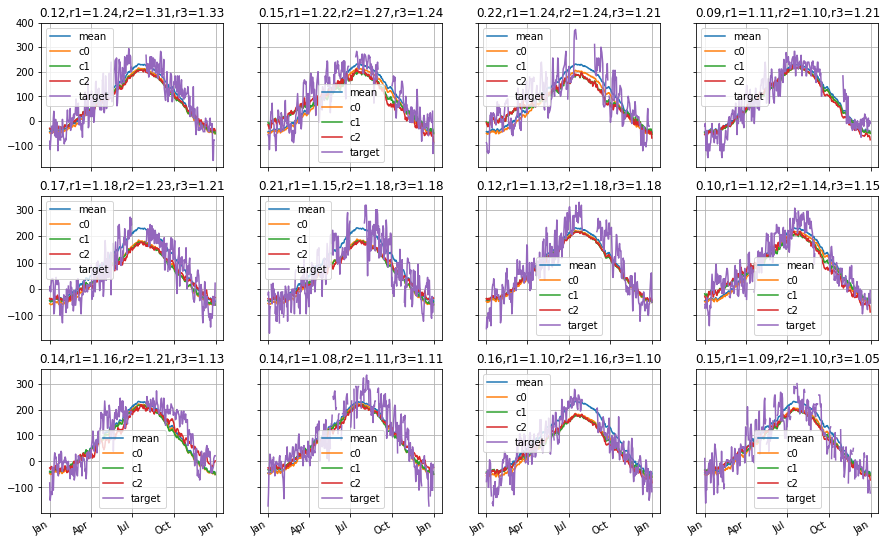

In [22]:
plot_recon_grid(rows)

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

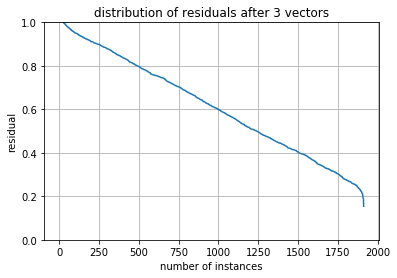

In [23]:
res3=df3.select('res_3').collect()
R3=[r['res_3'] for r in res3]
plot(R3)
title('distribution of residuals after 3 vectors')
xlabel('number of instances')
ylabel('residual')
ylim([0,1])
grid()

In [24]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [27]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
4.6M	../../Data/Weather/US_Weather_SBSSBSBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.1M	../../Data/Weather/decon_SBSSBSBB_PRCP.parquet
